## This is for the exam project


In [15]:
##Imports
from time import sleep
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from bs4 import BeautifulSoup as soup
import bs4
import requests
import re
import sys
import numpy as np

### Numberplate to string without img handling

In [2]:
import cv2
import pytesseract
#pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/Cellar/tesseract/4.1.1/bin/tesseract'
img = cv2.imread("./images/numberplate3.png")
text = pytesseract.image_to_string(img)
print(text)


BW 80 777

 



### Numberplate to string

Nummerpladen er: CM58 541



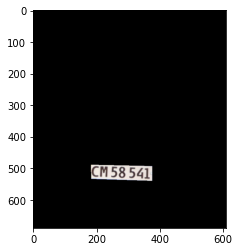

In [29]:
import cv2
import imutils
import numpy as np
from matplotlib import pyplot as plt
import pytesseract

#Windows
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

#M1
#ytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/Cellar/tesseract/4.1.1/bin/tesseract'

#Import image and resize it
img = cv2.imread('./images/aygo2.png', cv2.IMREAD_COLOR)
img = imutils.resize(img, width=610)

#Gray scale 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Blur to reduce noise
gray = cv2.bilateralFilter(gray, 13, 15, 15)

#Edge detection
edged = cv2.Canny(gray, 30, 200)

contours = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None

#Find contours in the edged image
(cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30]

NumberPlateCnt = None 
count = 0
#Loop over contours
for c in cnts:
	#Approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    #If the approximated contour has four points, then assume that screen is found
    if len(approx) == 4:  
        NumberPlateCnt = approx 
        break

#Mask the part other than the numberplate
mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[NumberPlateCnt],0,255,-1)
new_image = cv2.bitwise_and(img,img,mask=mask)

#Crop the image 
(x, y) = np.where(mask == 255)
(topx, topy) = (np.min(x), np.min(y))
(bottomx, bottomy) = (np.max(x), np.max(y))
Cropped = gray[topx:bottomx+1, topy:bottomy+1]

#Read the number plate
config = ('-l eng --oem 1 --psm 3')
text = pytesseract.image_to_string(Cropped, config=config)
print("Nummerpladen er:",text)
plt.imshow(new_image)

cv2.waitKey(0)
cv2.destroyAllWindows() 

### Entering numberplate on nummerplade.net to find model

In [3]:
print("Starting up..")
profile = webdriver.FirefoxProfile()
profile.set_preference("general.useragent.override", "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:81.0) Gecko/20100101 Firefox/81.0")
options = Options()
options.headless = True

#M1
#browser = webdriver.Chrome(executable_path="/Users/frederikdahl/chromedriver/chromedriver")

#Windows
browser = webdriver.Firefox(options=options)

browser.get("https://www.nummerplade.net/")

print("Got Browser")

browser.implicitly_wait(3)

#cookie_button = browser.find_element_by_css_selector('div.coi-banner__page-footer:nth-child(2) > button:nth-child(2)')
#cookie_button.click()
#print("Cookie Button Clicked..")
#sleep(3) 

search_field = browser.find_element_by_id('search_regnr')

search_field.send_keys(text)
#search_field.send_keys("CM 58 541")

button = browser.find_element_by_id('search_regnr_button')
button.click()
print("Search Entered")
sleep(3)

print()

page_source = browser.page_source
page_soup = soup(page_source,'html.parser')
res = page_soup.select_one("#maerke").text +" "+ page_soup.select_one("#model").text + " "

page_source = browser.page_source
page_soup = soup(page_source,'html.parser')
search_car_year = page_soup.select_one("#model_aar").text +" " 
search_car_km = page_soup.select_one("#box-overblik-data-overblik_kmcheck > div > small").text + " "
print("Preregex: " + search_car_km)

filter_search_km = re.sub("[^0-9]+", "",search_car_km)
search_car_km = filter_search_km


print("Search_car_km: " + search_car_km)
print("Search_car_year: " + search_car_year)
print("Mærke/model på søgte bil: ", res)
browser.quit()

Starting up..
Got Browser
Search Entered

Preregex: KM tæller ved seneste syn: 93.000 
Search_car_km: 93000
Search_car_year: 2015 
Mærke/model på søgte bil:  Toyota Aygo 


### Searching for model on bilbasen to get model,price,km, 

In [4]:
base_url = 'https://www.bilbasen.dk/'

class my_car:
    def __init__(self, url):
        self.base_url = url
        self.car_list = []
        
        print("Starting up...")
        
        profile = webdriver.FirefoxProfile()
        profile.set_preference("general.useragent.override", "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:81.0) Gecko/20100101 Firefox/81.0")
        options = Options()
        options.headless = True
        
        #Windows
        self.browser = webdriver.Firefox(options=options)
        
        #M1 
        #self.browser  = webdriver.Chrome(executable_path="/Users/frederikdahl/chromedriver/chromedriver")
        
        self.browser.get(self.base_url)
        print("Got Browser")
        
        self.browser.implicitly_wait(3)
        
    def click_cookie_button(self):
        try:
            cookie_button = self.browser.find_element_by_id('onetrust-accept-btn-handler')
            try:
                cookie_button.click()
                print("Cookie Button Clicked")
                sleep(3)   
            except Exception as err:
                print('Error With Cookie Button:', err)
        except Exception as err:
            print(err)
            
    def click_leasing_button(self):
        try:
            leasing_button = self.browser.find_element_by_css_selector("label[data-track-action='leasing-toggle']")
            try:
                leasing_button.click()
                print("Leasing Button Clicked")
                sleep(3)   
            except Exception as err:
                print('Error With Leasing Button:', err)
        except Exception as err:
            print(err)
        
    def search_in_search_bar(self, search_text):
        try:
            search_field = self.browser.find_element_by_class_name('react-autosuggest__input')
            search_field.send_keys(search_text)
            search_field.submit()
            print("Search Bar Entered")
            sleep(3)

        except Exception as err:
            print('Error with Search', err)

    def get_car_list(self):
        print("Souping Site")
        print()
        page_source = self.browser.page_source
        page_soup = soup(page_source,'html.parser')
        car_list_plus = page_soup.findAll("div",{"class":"row listing listing-plus bb-listing-clickable"})
        car_list_discount = page_soup.findAll("div",{"class":"row listing listing-discount bb-listing-clickable"})
        full_list = car_list_plus + car_list_discount
        print("Cars found: " + str(len(full_list)))
        for car in full_list:
            name = car.find("a",{"class":"listing-heading darkLink"}).contents[0]
            km = int(car.findAll("div",{"class":"col-xs-2 listing-data"})[1].contents[0].replace('.',''))
            price = car.find("div",{"class":"col-xs-3 listing-price"}).contents[0].replace(' kr.','').replace('.','')
            year = int(car.findAll("div",{"class":"col-xs-2 listing-data"})[2].contents[0])
            car_info = {"name": name, "km": km, "price": price, "year": year}
            self.car_list.append(car_info)
            print(car_info) 
            
    def close_browser(self):
        self.browser.close()
    
bilbasen = my_car(base_url)
bilbasen.click_cookie_button()
bilbasen.click_leasing_button()
bilbasen.search_in_search_bar(res)
print("Searching for: " + res)
bilbasen.get_car_list()
bilbasen.close_browser()
make_me_dataframe = bilbasen.car_list

Starting up...
Got Browser
Cookie Button Clicked
Leasing Button Clicked
Search Bar Entered
Searching for: Toyota Aygo 
Souping Site

Cars found: 32
{'name': 'Toyota Aygo 1,0 VVT-i T2 Air Connect 5d', 'km': 104000, 'price': '46900', 'year': 2014}
{'name': 'Toyota Aygo 1,0  5d', 'km': 205000, 'price': '26400', 'year': 2010}
{'name': 'Toyota Aygo 1,0 VVT-i T1 5d', 'km': 138000, 'price': '39900', 'year': 2012}
{'name': 'Toyota Aygo 1,0 VVT-i x-play Touch 5d', 'km': 57000, 'price': '59990', 'year': 2015}
{'name': 'Toyota Aygo 1,0 VVT-i x-play Touch 5d', 'km': 113000, 'price': '64900', 'year': 2015}
{'name': 'Toyota Aygo 1,0 VVT-i Black&White 5d', 'km': 179000, 'price': '35000', 'year': 2014}
{'name': 'Toyota Aygo 1,0 VVT-i x 5d', 'km': 35000, 'price': '87900', 'year': 2018}
{'name': 'Toyota Aygo 1,0 VVT-i x-wave Sky 5d', 'km': 81700, 'price': '72900', 'year': 2015}
{'name': 'Toyota Aygo 1,0 VVT-i x 5d', 'km': 91000, 'price': '54900', 'year': 2015}
{'name': 'Toyota Aygo 1,0 VVT-i T2 Air 5d',

In [5]:
import pandas as pd

# Import the data into a Pandas dataframe 
data = pd.DataFrame(make_me_dataframe)
# Show the head of the dataframe 
data.head()

,name,km,price,year
0,"Toyota Aygo 1,0 VVT-i T2 Air Connect 5d",104000,46900,2014
1,"Toyota Aygo 1,0 5d",205000,26400,2010
2,"Toyota Aygo 1,0 VVT-i T1 5d",138000,39900,2012
3,"Toyota Aygo 1,0 VVT-i x-play Touch 5d",57000,59990,2015
4,"Toyota Aygo 1,0 VVT-i x-play Touch 5d",113000,64900,2015


In [6]:
from sklearn import preprocessing
import sklearn.linear_model


#Remove outliers fra data (dataFrame)

#Hint ???: df[column name'] < df['column name'].quantile(0.90)
#outliers = gasoline[gasoline] < dataFrame['Fuel Information.Fuel Type'].quantile(0.90)

## Remove outliers 


## 

#Only use 2 features : 'Fuel Information.Highway mpg' and 'Engine Information.Engine Statistics.Horsepower'

features = data[['km', 'year', 'price']]


#Normalize data (reduce values to be between 0 and 1)
scaler = preprocessing.MinMaxScaler()
names = features.columns
d = scaler.fit_transform(features)
scaled_df = pd.DataFrame(d, columns=names)
scaled_df.head()



,km,year,price
0,0.507317,0.571429,0.252612
1,1.000000,0.285714,0.017224
2,0.673171,0.428571,0.172236
3,0.278049,0.642857,0.402917
4,0.551220,0.642857,0.459295


In [7]:
# Describing the data 
data.describe()

,km,year
count,32.000000,32.000000
mean,72481.968750,2015.218750
std,54768.431961,3.076806
min,0.000000,2006.000000
25%,33000.000000,2014.000000
50%,58000.000000,2015.000000
75%,107000.000000,2017.250000
max,205000.000000,2020.000000


In [8]:
# Setting X (km and year) and Y (price)

X = data[['km', 'year']]
y = data['price']


# Dividing data into training and test sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
# Training the model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
# Showing coefficient

coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
km,-0.191035
year,4431.606272


In [11]:
# Showing interception with y

intercept = regressor.intercept_
intercept

-8848301.589181408

In [12]:
# Predicting the results  
y_pred = regressor.predict(X_test) 

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
11,111990,103543.080878
22,37900,48031.605748
10,106900,103161.011831
2,39900,41727.466478
16,44900,57774.366439
14,64900,70915.962968
28,79980,80314.466847


In [ ]:
""""import matplotlib.pyplot as plt
X_pred = [2010,2011,2012,2013,2014,2015,2016]

plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(7, 3.5))

ax.plot(X_pred, y_pred, color='k', label='Regression model')
ax.scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('Price', fontsize=14)
ax.set_xlabel('KM and production year', fontsize=14)
ax.legend(facecolor='white', fontsize=11)
ax.text(0.55, 0.15, '$y = %.2f x_1 - %.2f $' % (regressor.coef_[0], abs(regressor.intercept_)), fontsize=17, transform=ax.transAxes)

fig.tight_layout()""""

In [13]:
# Predicting result based on car values 

#Find values from the car we're searching for

#search_car_km => Needs to be casted to an integer 
#search_car_year => Needs to be casted to an integer 

predicted_car_value = regressor.predict([[int(search_car_km),int(search_car_year)]]) 
print(predicted_car_value)

[63618.8388453]


In [16]:
# Data analysis of what and how accurate the data was 

# Vi skal kunne forklare de her tal, de er gode. Men øøøh :) 
# Se bunden af artiklen: https://stackabuse.com/linear-regression-in-python-with-scikit-learn/

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 6195.682252993009
Mean Squared Error: 56196076.2361125
Root Mean Squared Error: 7496.4042204321195
